In [1]:
%cd ..

C:\Users\Dmytro_Shvetsov\Desktop\super-resolution-engine


In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

tf.debugging.set_log_device_placement(False)

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

dry_run = False

In [3]:
import tensorflow as tf 
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

True
[]


In [4]:
def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save(f'{filename}.jpg')
    print(f'Saved as {filename}.jpg')

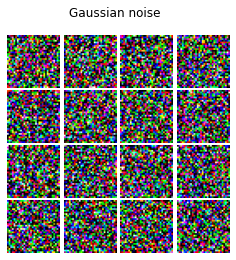

In [5]:
from utils import plot_multiple_images, plot_single_image


plot_multiple_images(tf.random.normal((2, 16, 32, 32, 3)) * 255, 'Gaussian noise')

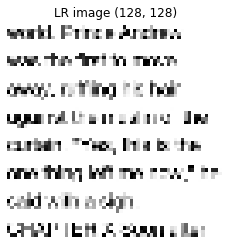

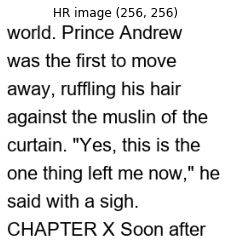

In [6]:
from esrgan import ESRGAN
from os import path
from data import CLEAR_IMAGES_DIR, get_dataset


# ds_iter = 

# model = ESRGAN()
# model.load()

# for i in range(3):
X, y = next(iter(get_dataset(path.join(CLEAR_IMAGES_DIR, 'train')).batch(1)))
#     enhanced_batch = model(X)
# plot_multiple_images([tf.expand_dims(X[0], axis=0), tf.expand_dims(X[1], axis=0)], 'Enhanced vs groud truth HR images', cmap='gray', figsize=(6, 6))
plot_single_image(X[0], 'LR image (128, 128)')
plt.figure()
plot_single_image(y[0], 'HR image (256, 256)')

In [7]:
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, Conv2D, Dense
from tensorflow.keras import Model


class Discriminator(Model):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape)
        self.lrelu1 = LeakyReLU()
        self.dropout1 = Dropout(0.3)
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.lrelu2 = LeakyReLU()
        self.dropout2 = Dropout(0.3)
        
        self.conv3 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')
        self.lrelu3 = LeakyReLU()
        
        self.conv4 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')
        self.lrelu4 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation=None)
    
    def __call__(self, X, training=True):
        outputs = self.conv1(X)
        outputs = self.lrelu1(outputs)
        outputs = self.dropout1(outputs, training=training)
        
        outputs = self.conv2(outputs)
        outputs = self.lrelu2(outputs)
        outputs = self.dropout2(outputs, training=training)

        outputs = self.conv3(outputs)
        outputs = self.lrelu3(outputs)
        
        outputs = self.conv4(outputs)
        outputs = self.lrelu4(outputs)
        
#         print(outputs.shape)

        return self.dense(self.flatten(outputs))
    
    
    def call(self, inputs, training=True):
        return self(inputs, training=training)

    
def test_discriminator():
    batch_size = 8
    inp_shape = batch_size, 256, 256, 3
    d = Discriminator(input_shape=inp_shape)

    assert d(tf.ones(inp_shape)).shape == (batch_size, 1)
    print('Correct discriminator outputs.')
    

test_discriminator()

Correct discriminator outputs.


In [8]:
class TunedESRGAN(Model):
    def __init__(self, input_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.base_model = hub.KerasLayer('https://tfhub.dev/captain-pool/esrgan-tf2/1', input_shape=input_shape, trainable=True)
        
    def __call__(self, X, training=True):
        return self.base_model(X, training=training)
    
    def call(self, inputs, training=True):
        return self(inputs, training=training)


In [9]:
# from core.pan import PixelAttentionSRNetwork
from itertools import cycle

    
# # b = SCPA(3)
# # b(tf.ones((8, 64, 64, 3))).shape
batch_size = 32
inp_shape = (batch_size, 64, 64, 3)
# net = PixelAttentionSRNetwork(feat_extr_n_filters=30, upsamp_n_filters=20, n_blocks=16, scale=4, input_shape=inp_shape)
# net.build(inp_shape)
# # print(net(tf.ones(inp_shape)).shape)
# net.summary()

In [10]:
# gan = TunedESRGAN(inp_shape)
# gan.build(inp_shape)
# gan.summary()

In [11]:
# import time


# t = time.time()
# gan(tf.ones(inp_shape))

# print('Single forward step for ESRGAN took', time.time() - t) # 16.393023014068604

In [12]:
# t = time.time()
# net(tf.ones(inp_shape))

# print('Single forward step for PAN took', time.time() - t) # 3.076345920562744

In [13]:
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
sigmoid = tf.keras.activations.sigmoid


# def discriminator_loss(real_outputs, fake_outputs):
#     return (cross_entropy_loss(tf.zeros_like(fake_outputs), fake_outputs) + 
#             cross_entropy_loss(tf.ones_like(real_outputs), real_outputs))


# def generator_loss(fake_outputs):
#     return cross_entropy_loss(tf.ones_like(fake_outputs), fake_outputs)


def discriminator_loss(real_outputs, fake_outputs):
    """Relativistic discriminator loss"""
    # both real_outputs and fake_outputs are logits(non-transformed discriminator output)
    # real data is more realistic than fake data 
    real_realistics_coeff = sigmoid(real_outputs - tf.reduce_mean(fake_outputs))
    # fake data is less realistic than real data 
    fake_realistics_coeff = sigmoid(fake_outputs - tf.reduce_mean(real_outputs))
    
    return (cross_entropy_loss(tf.zeros_like(fake_outputs), real_realistics_coeff) + 
            cross_entropy_loss(tf.ones_like(real_outputs), fake_realistics_coeff))


def generator_loss(real_outputs, fake_outputs):
    """Relativistic generator loss"""
    # real data is more realistic than fake data 
    real_realistics_coeff = sigmoid(real_outputs - tf.reduce_mean(fake_outputs))
    # fake data is less realistic than real data 
    fake_realistics_coeff = sigmoid(fake_outputs - tf.reduce_mean(real_outputs))
    
    return (cross_entropy_loss(tf.ones_like(fake_outputs), real_realistics_coeff) + 
            cross_entropy_loss(tf.zeros_like(real_outputs), fake_realistics_coeff))


In [14]:
from os import path
from data import CLEAR_IMAGES_DIR, LR_IMAGE_SIZE, HR_IMAGE_SIZE
from utils import plot_multiple_images, plot_single_image
from core.pan import PixelAttentionSRNetwork
from itertools import cycle


input_lr_shape = (None, *LR_IMAGE_SIZE, 3)
input_hr_shape = (None, *HR_IMAGE_SIZE, 3)

cpu = '/CPU:0'
# gpu = '/GPU:0'

device = cpu

max_ckpt_to_keep = 3
checkpoint_dir = './model/x4_checkpoints'
checkpoint_name = 'pix-att-net-ckpt'


with tf.device(device):
    test_dataset = cycle(get_dataset(path.join(CLEAR_IMAGES_DIR, 'train')).batch(4))
    
    sr_net = PixelAttentionSRNetwork(input_lr_shape, feat_extr_n_filters=30, upsamp_n_filters=20, n_blocks=16, scale=4)
    
    checkpoint = tf.train.Checkpoint(sr_net=sr_net)

    sr_net.build(input_lr_shape)

    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_ckpt_to_keep, checkpoint_name=checkpoint_name)

    # try restoring previous checkpoint or initialize a new one
    restored_ckpt_path = ckpt_manager.restore_or_initialize()
    if restored_ckpt_path:
        print('Restored state from checkpoint {}'.format(repr(restored_ckpt_path)))



Restored state from checkpoint './model/x4_checkpoints\\pix-att-net-ckpt-466'


(4, 256, 256, 3)
Max possible psnr inf


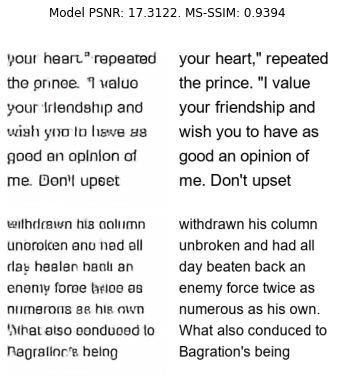

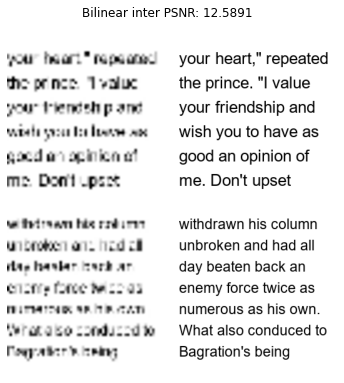

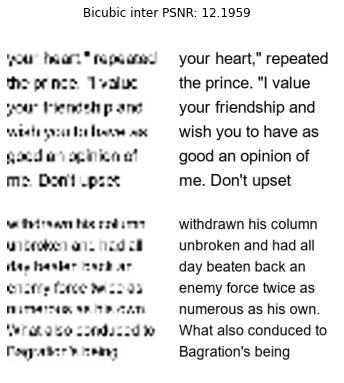

In [15]:
X, y = next(test_dataset)

y_hat = tf.clip_by_value(sr_net(X, training=False), 0, 255)
print(y_hat.shape)
print('Max possible psnr', round(float(tf.reduce_mean(tf.image.psnr(y, y, 255))), 4))
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
msssim = round(float(tf.reduce_mean(tf.image.ssim_multiscale(y_hat, y, 255))), 4)
# print(msssim)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Model PSNR: {psnr}. MS-SSIM: {msssim}')

y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bilinear')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')

y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bicubic')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bicubic inter PSNR: {psnr}')

# model = ESRGAN()
# model.load()

# y_hat = tf.clip_by_value(model(X), 0, 255)
# psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
# plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')

Max possible psnr inf


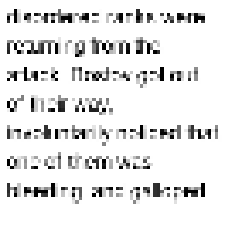

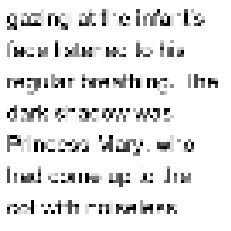

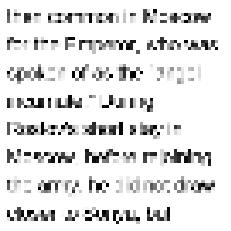

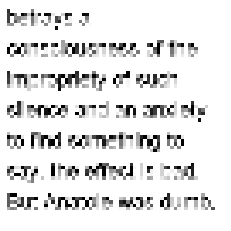

<Figure size 432x288 with 0 Axes>

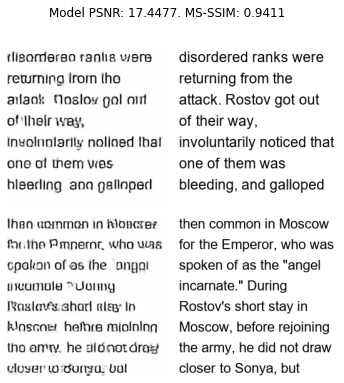

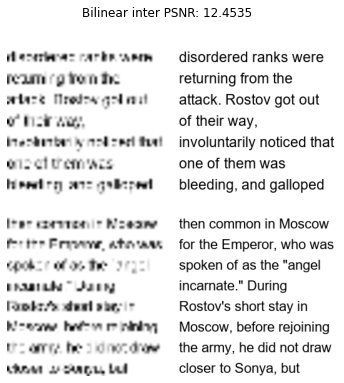

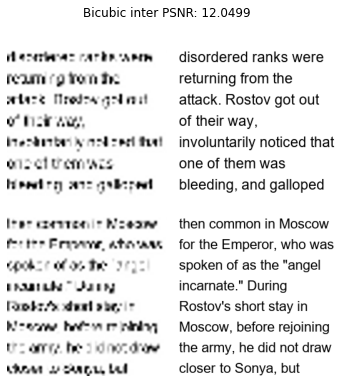

In [16]:
X, y = next(test_dataset)

for im in X:
    plot_single_image(im)
    plt.figure()

y_hat = tf.clip_by_value(sr_net(X, training=False), 0, 255)
print('Max possible psnr', round(float(tf.reduce_mean(tf.image.psnr(y, y, 255))), 4))
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
msssim = round(float(tf.reduce_mean(tf.image.ssim_multiscale(y_hat, y, 255))), 4)
# print(msssim)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Model PSNR: {psnr}. MS-SSIM: {msssim}')

y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bilinear')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')

y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bicubic')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bicubic inter PSNR: {psnr}')

# model = ESRGAN()
# model.load()

# y_hat = tf.clip_by_value(model(X), 0, 255)
# psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
# plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')

In [17]:
# psnr_test_model = gen
psnr_test_model = sr_net

In [18]:
# mean_batch_psnr = 0.0

# with tf.device('/CPU:0'):
#     batch_size = 50
#     dataset = get_dataset(path.join(CLEAR_IMAGES_DIR, 'test'))
#     n_batches = 0
#     for batch_x, batch_y in dataset.batch(batch_size):
#         mean_batch_psnr += tf.reduce_mean(tf.image.psnr(psnr_test_model(batch_x), batch_y, 255))
#         n_batches += 1

# mean_batch_psnr /= n_batches
# print('PSNR:', float(mean_batch_psnr))
# # 31.12.20 - 17.705045700073242 - x2 l1 loss, 15 epochs (no metric growth after 5-10 epochs)
# # 02.01.21 - 19.35519027709961 - x2 l1 + ms-ssim loss, 17 epochs (undertrained)  
# # 09.01.21 - 24.953815460205078 - x2 l1 + ms-ssim loss, 40 epochs
# # 17.01.21 - 17.42136573791504 - x4 l1 + ms-ssim loss

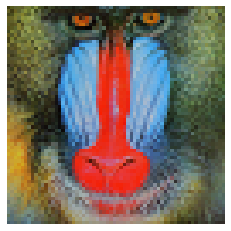

tf.Tensor([19.56195], shape=(1,), dtype=float32)


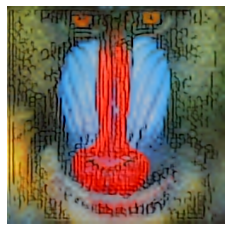

In [19]:
from data import read_image
from PIL import Image


lr = read_image('./sample_images/monkey.png', (64, 64))
plot_single_image(lr)
plt.show()
hr = tf.clip_by_value(sr_net(tf.expand_dims(lr, 0)), 0, 255)
# print(hr.shape)
gt_hr = read_image('./sample_images/gt_high_res.jpg', (256, 256))
print(tf.image.psnr(gt_hr, hr, 255))
hr = Image.fromarray(hr.numpy().astype(np.uint8)[0])
plot_single_image(hr)
plt.show()


In [20]:
from json import load


with open('./data/img/clear_words_coordinates.json') as fid:
    annot = load(fid)
    
list(annot.keys())[:3]

['image0', 'image1', 'image2']

In [21]:
def get_true_text(img_name):
    return ' '.join((w_st['word'] for w_st in annot[img_name])) + '\f'

repr(get_true_text('image0'))

"'Title War and Peace\\n Author: Leo Tolstoy\\n Posting Date: January\\n 10, 2009 Release Date:\\n April, 2001 Language:\\n English WAR AND\\n PEACE By Leo Tolstoy\\n\\x0c'"

In [22]:
# dataset = get_dataset(path.join(CLEAR_IMAGES_DIR, 'test'))
# # from metrics import 
# mean_relative_distance = 0
# for pred_text in model2.recognize_text(test_images):
#     true_text = take_clear_image_text(json_data, f'clear_image{i}.png')
#     relative_distance = int(edit_distance(pred_text, true_text)) / len(true_text)
#     mean_relative_distance += relative_distance
# mean_relative_distance /= len(test_images)

# test_data

In [23]:
import pytesseract as tesseract


# specify path to the preinstalled binary file of tesseract
tesseract.pytesseract.tesseract_cmd = r'C:\Users\Dmytro_Shvetsov\Desktop\tesseract\tesseract.exe'
print('Tesseract version: ', tesseract.get_tesseract_version())

Tesseract version:  5.0.0-alpha.20201127


In [24]:
dir(tesseract)

['ALTONotSupported',
 'Output',
 'TSVNotSupported',
 'TesseractError',
 'TesseractNotFoundError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'get_tesseract_version',
 'image_to_alto_xml',
 'image_to_boxes',
 'image_to_data',
 'image_to_osd',
 'image_to_pdf_or_hocr',
 'image_to_string',
 'pytesseract',
 'run_and_get_output']

In [25]:
plt.imshow(hr_im)


NameError: name 'hr_im' is not defined

In [26]:
from src.data import prepare_example
from metrics import relative_distance
from glob import glob

lr_mean_relative_distance = 0.0
sr_mean_relative_distance = 0.0

with tf.device('/CPU:0'):
    test_img_fps = glob(path.join(CLEAR_IMAGES_DIR, 'test/*'))
    for fp in test_img_fps:
        lr_im, hr_im, fname = prepare_example(fp, ret_img_name=True)
#         plot_single_image(lr_im)
#         plt.figure()
        text_true = get_true_text(fname.numpy().decode())
        text_pred = tesseract.image_to_string(lr_im.numpy().astype(np.uint8))
        rel_dist = relative_distance(text_true, text_pred)
        lr_mean_relative_distance += rel_dist
#         print(repr(text_pred), repr(text_true))
#         print(1, lr_mean_relative_distance)
        
        sr_img = tf.clip_by_value(sr_net(tf.expand_dims(lr_im, 0), training=False)[0], 0, 255).numpy().astype(np.uint8)
#         plot_single_image(sr_img)
#         print(sr_img.shape)
        text_pred = tesseract.image_to_string(sr_img)
        rel_dist = relative_distance(text_true, text_pred)
        sr_mean_relative_distance += rel_dist
#         print(repr(text_pred), repr(text_true))
#         print(text_pred)
#         print(2, sr_mean_relative_distance)
#         plt.imshow(sr_img)
#         print(lr_im.shape, hr_im.shape, fname)
#         break

lr_mean_relative_distance /= len(test_img_fps)
sr_mean_relative_distance /= len(test_img_fps)
print('Mean relative distance without sr', float(lr_mean_relative_distance))
print('Mean relative distance with sr', float(sr_mean_relative_distance))

Mean relative distance without sr 0.9772478583221865
Mean relative distance with sr 0.2746786971250391
